In [12]:

import soundfile
import librosa
from collections import Counter
import numpy as np
import pandas as pd
import os
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize


In [13]:
def preprocess_audio(file_path, target_sr=16000):
    try: 
        audio_signal, sr = librosa.load(file_path, sr=target_sr)
        audio_signal, _ = librosa.effects.trim(audio_signal)
  
        audio_signal = librosa.util.normalize(audio_signal)
        
        return audio_signal, sr

    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        return None, None
    except Exception as e:
        print(f"An error occurred while processing '{file_path}': {e}")
        return None, None


In [14]:


emotion_map = {
    "SAD": "sad",
    "ANG": "angry",
    "HAP": "happy",
    "NEU": "neutral",
    "DIS": "disgust",
    "FEA": "fear"
}

AVAILABLE_EMOTIONS = {"sad", "angry", "happy", "neutral"}


In [15]:

def extract_audio_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr).T, axis=0)
    features = np.hstack([mfccs, chroma, spectral_contrast])
    return features


In [16]:

audio_dir = 'archive/AudioWAV'

audio_features = []
labels = []

for file in os.listdir(audio_dir):
    if file.endswith('.wav'):
        file_path = os.path.join(audio_dir, file)
        emotion = file.split('_')[2]
        emotion_label = emotion_map.get(emotion)
        if emotion_label in AVAILABLE_EMOTIONS:
            features = extract_audio_features(file_path)
            audio_features.append(features)
            labels.append(emotion_label)

audio_df = pd.DataFrame(audio_features)
audio_df['label'] = labels


c:\Users\karth\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [17]:
X = audio_df.iloc[:, :-1].values
y = audio_df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best Parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
Accuracy: 0.57

Classification Report:
               precision    recall  f1-score   support

       angry       0.73      0.63      0.68       245
       happy       0.46      0.43      0.44       251
     neutral       0.43      0.46      0.44       227
         sad       0.64      0.73      0.68       257

    accuracy                           0.57       980
   macro avg       0.57      0.56      0.56       980
weighted avg       0.57      0.57      0.56       980


Confusion Matrix:
 [[155  71  15   4]
 [ 55 107  62  27]
 [  1  46 104  76]
 [  0   8  61 188]]


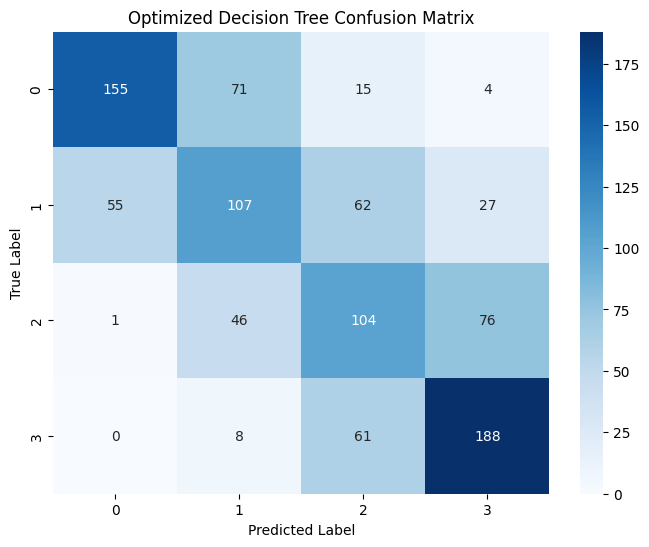

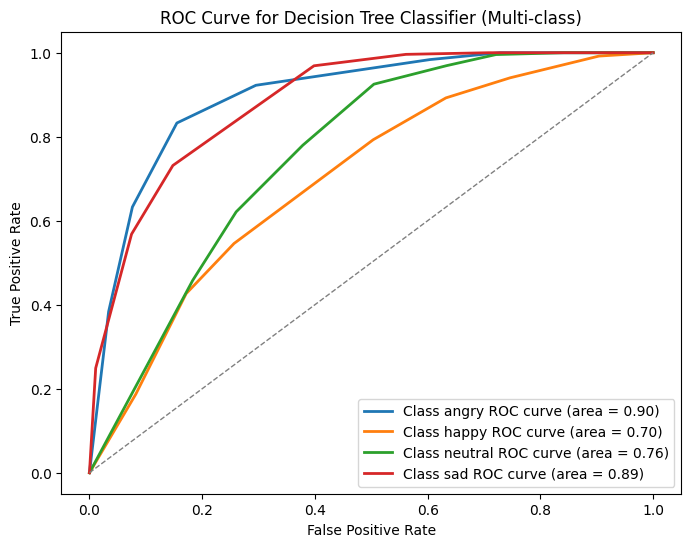

Class distribution in y_train: {'neutral': 860, 'sad': 1014, 'angry': 1026, 'happy': 1020}
Class distribution in y_test: {'happy': 251, 'angry': 245, 'neutral': 227, 'sad': 257}


In [18]:
 
from sklearn.metrics import classification_report


param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [3, 6, 9, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
 
dtree = DecisionTreeClassifier(random_state=0)
 
grid_search = GridSearchCV(
    estimator=dtree,
    param_grid=param_grid,
    scoring='accuracy',   
    cv=5,  
    verbose=1,   
    n_jobs=-1   
) 
grid_search.fit(X_train, y_train) 
print(f"Best Parameters: {grid_search.best_params_}")
best_dtree = grid_search.best_estimator_
 
y_pred = best_dtree.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred)) 
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

plot_confusion_matrix(y_test, y_pred, title="Optimized Decision Tree Confusion Matrix") 
n_classes = len(set(y_test))

if n_classes == 2: 
    y_probs = best_dtree.predict_proba(X_test)[:, 1]   
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
 
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Decision Tree Classifier')
    plt.legend(loc="lower right")
    plt.show()

else:
 
    try: 
        classes = sorted(list(set(y_train)))  
        y_test_binarized = label_binarize(y_test, classes=classes)
        y_probs = best_dtree.predict_proba(X_test)    
        plt.figure(figsize=(8, 6))
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_probs[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'Class {classes[i]} ROC curve (area = {roc_auc:.2f})')

        plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve for Decision Tree Classifier (Multi-class)')
        plt.legend(loc="lower right")
        plt.show()

    except ValueError as e:
        print(f"Error during ROC calculation: {e}")
        print("Ensure that y_test contains all necessary classes.")
 
print("Class distribution in y_train:", dict(Counter(y_train)))
print("Class distribution in y_test:", dict(Counter(y_test)))

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy: 0.67

Classification Report:
               precision    recall  f1-score   support

       angry       0.75      0.75      0.75       245
       happy       0.59      0.56      0.58       251
     neutral       0.58      0.57      0.58       227
         sad       0.71      0.77      0.74       257

    accuracy                           0.67       980
   macro avg       0.66      0.66      0.66       980
weighted avg       0.66      0.67      0.66       980


Confusion Matrix:
 [[184  47  12   2]
 [ 53 141  38  19]
 [  5  34 130  58]
 [  2  15  43 197]]


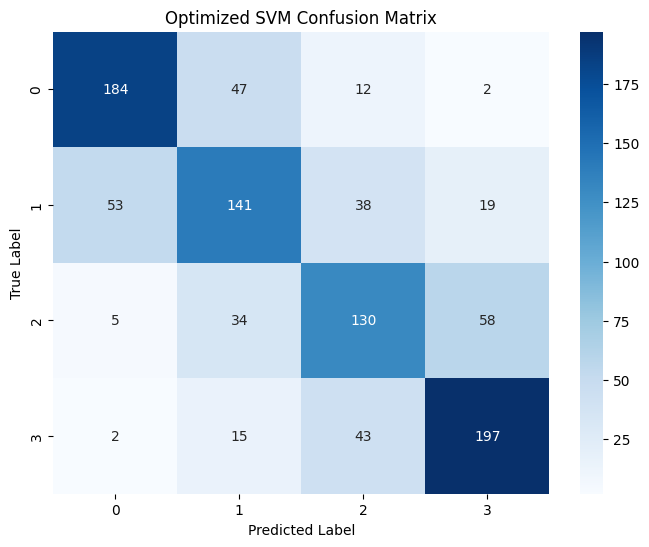

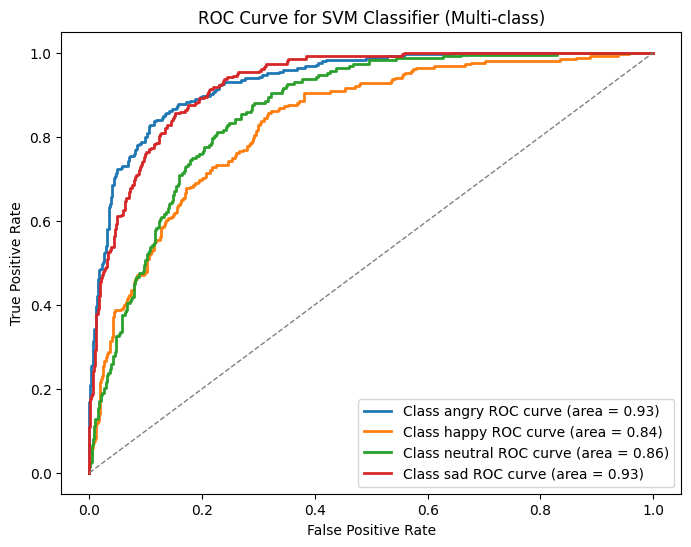

Class distribution in y_train: {'neutral': 860, 'sad': 1014, 'angry': 1026, 'happy': 1020}
Class distribution in y_test: {'happy': 251, 'angry': 245, 'neutral': 227, 'sad': 257}


In [19]:
from sklearn.discriminant_analysis import StandardScaler


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
 
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale']
}
 
svm = SVC(probability=True, random_state=0)
 
grid_search = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,   
    verbose=1,
    n_jobs=-1   
)
 
grid_search.fit(X_train_scaled, y_train)
 
print(f"Best Parameters: {grid_search.best_params_}")
best_svm = grid_search.best_estimator_
 
svm_predictions = best_svm.predict(X_test_scaled)
print(f"Accuracy: {accuracy_score(y_test, svm_predictions):.2f}")
print("\nClassification Report:\n", classification_report(y_test, svm_predictions))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, svm_predictions))
 
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

plot_confusion_matrix(y_test, svm_predictions, title="Optimized SVM Confusion Matrix")
 
n_classes = len(set(y_test))

if n_classes == 2: 
    y_probs = best_svm.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for SVM Classifier')
    plt.legend(loc="lower right")
    plt.show()

else:
    try:
        classes = sorted(list(set(y_train)))
        y_test_binarized = label_binarize(y_test, classes=classes)
        y_probs = best_svm.predict_proba(X_test_scaled)

        plt.figure(figsize=(8, 6))
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_probs[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'Class {classes[i]} ROC curve (area = {roc_auc:.2f})')

        plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve for SVM Classifier (Multi-class)')
        plt.legend(loc="lower right")
        plt.show()

    except ValueError as e:
        print(f"Error during ROC calculation: {e}")
        print("Ensure that y_test contains all necessary classes.")
 
print("Class distribution in y_train:", dict(Counter(y_train)))
print("Class distribution in y_test:", dict(Counter(y_test)))


In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
 
param_grid = {
    'n_estimators': [50, 100],   
    'max_depth': [None, 10],  
    'min_samples_split': [2, 5],   
    'min_samples_leaf': [1, 2],   
    'bootstrap': [True]   
}
 
rf_classifier = RandomForestClassifier(random_state=0) 
grid_search = GridSearchCV(
    estimator=rf_classifier,
    param_grid=param_grid,
    cv=3,  
    scoring='accuracy',
    verbose=2,
    n_jobs=-1   
)
 
grid_search.fit(X_train, y_train)
 
print("Best Hyperparameters:", grid_search.best_params_)
 
best_rf = grid_search.best_estimator_
 
rf_predictions = best_rf.predict(X_test) 
print("[Random Forest] Accuracy:", accuracy_score(y_test, rf_predictions))
print("\nClassification Report:\n", classification_report(y_test, rf_predictions))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, rf_predictions))


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Hyperparameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
[Random Forest] Accuracy: 0.6234693877551021

Classification Report:
               precision    recall  f1-score   support

       angry       0.72      0.76      0.74       245
       happy       0.53      0.44      0.48       251
     neutral       0.53      0.55      0.54       227
         sad       0.68      0.74      0.71       257

    accuracy                           0.62       980
   macro avg       0.62      0.62      0.62       980
weighted avg       0.62      0.62      0.62       980


Confusion Matrix:
 [[186  44  13   2]
 [ 69 111  46  25]
 [  3  38 125  61]
 [  1  17  50 189]]


In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
 
param_grid = {
    'n_neighbors': [3, 5, 7],  
    'weights': ['uniform'],   
    'metric': ['euclidean']   
}
 
knn_classifier = KNeighborsClassifier()
 
grid_search = GridSearchCV(
    estimator=knn_classifier,
    param_grid=param_grid,
    cv=3,   
    scoring='accuracy',
    verbose=2,
    n_jobs=-1   
)
 
grid_search.fit(X_train_scaled, y_train)
 
print("Best Hyperparameters:", grid_search.best_params_)
 
best_knn = grid_search.best_estimator_
 
knn_predictions = best_knn.predict(X_test_scaled)
 
print("[Optimized KNN] Accuracy:", accuracy_score(y_test, knn_predictions))
print("\nClassification Report:\n", classification_report(y_test, knn_predictions))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, knn_predictions))


Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best Hyperparameters: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'uniform'}
[Optimized KNN] Accuracy: 0.563265306122449

Classification Report:
               precision    recall  f1-score   support

       angry       0.67      0.66      0.66       245
       happy       0.51      0.36      0.42       251
     neutral       0.45      0.50      0.47       227
         sad       0.61      0.73      0.66       257

    accuracy                           0.56       980
   macro avg       0.56      0.56      0.55       980
weighted avg       0.56      0.56      0.56       980


Confusion Matrix:
 [[161  51  25   8]
 [ 67  91  60  33]
 [  7  27 113  80]
 [  6  11  53 187]]


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'var_smoothing': np.float64(0.1)}
[Naive Bayes] Accuracy: 0.5744897959183674

Classification Report:
               precision    recall  f1-score   support

       angry       0.76      0.60      0.67       245
       happy       0.51      0.37      0.43       251
     neutral       0.43      0.59      0.50       227
         sad       0.65      0.73      0.69       257

    accuracy                           0.57       980
   macro avg       0.59      0.57      0.57       980
weighted avg       0.59      0.57      0.57       980


Confusion Matrix:
 [[148  65  28   4]
 [ 48  93  85  25]
 [  0  19 134  74]
 [  0   4  65 188]]


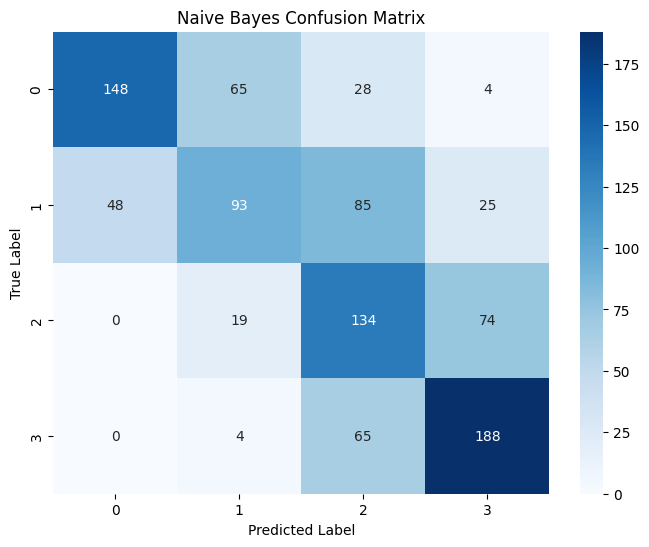

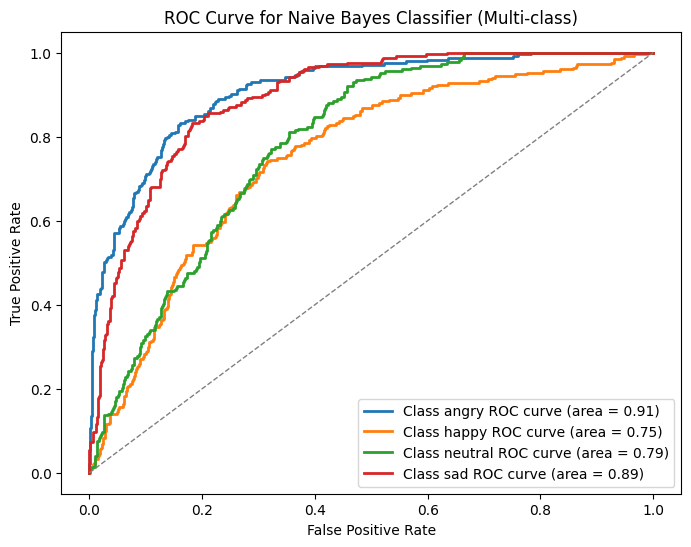

In [13]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
 
param_grid = {
    'var_smoothing': np.logspace(-9, 0, 10)   
}
 
nb_classifier = GaussianNB()
 
grid_search = GridSearchCV(
    estimator=nb_classifier,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5, 
    verbose=1,
    n_jobs=-1   
)
 
grid_search.fit(X_train, y_train)
 
print(f"Best Parameters: {grid_search.best_params_}")
best_nb_classifier = grid_search.best_estimator_
 
y_pred = best_nb_classifier.predict(X_test)
print("[Naive Bayes] Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
 
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

plot_confusion_matrix(y_test, y_pred, title="Naive Bayes Confusion Matrix")
 
n_classes = len(set(y_test))

if n_classes == 2: 
    y_probs = best_nb_classifier.predict_proba(X_test)[:, 1]   
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
 
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Naive Bayes Classifier')
    plt.legend(loc="lower right")
    plt.show()

else: 
    try: 
        classes = sorted(list(set(y_train)))   
        y_test_binarized = label_binarize(y_test, classes=classes)
        y_probs = best_nb_classifier.predict_proba(X_test) 
 
        plt.figure(figsize=(8, 6))
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_probs[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'Class {classes[i]} ROC curve (area = {roc_auc:.2f})')

        plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve for Naive Bayes Classifier (Multi-class)')
        plt.legend(loc="lower right")
        plt.show()

    except ValueError as e:
        print(f"Error during ROC calculation: {e}")
        print("Ensure that y_test contains all necessary classes.")